<b>Author:</b> Hatice Gulcin Ozer\
<b>Date: </b> December 5, 2020\
<b>Course:</b> BMI8050 - Applications of Machine Learning and Artificial Intelligence in Biomedical Informatics

# Multi-omics Integration with Deep Learning for Drug Response Prediction in AML

## Background

Adult acute myeloid leukemia (AML) is a type of cancer in which the bone marrow makes abnormal myeloblasts, red blood cells, or platelets. The 5-year survival rate for people 20 and older with AML is about 25%. AML is a heterogenous disease; cytogenetic and sequencing analyses have revealed at least 11 genetic classes of AML and over 20 subsets can be assigned when also considering cell differentiation states of the leukemic blasts. TCGA study reports nearly 2,000 somatically mutated genes observed across 200 patients (Cancer Genome Atlas Research Network, NEJM 2013). Also, many of the recurrent cytogenetic events and somatic mutations have been shown to carry prognostic importance.

Initial findings from the Beat AML program on a cohort of 672 tumour specimens collected from 562 patients were reported in Tyner et. al. Nature, 2018. Samples were assesed using whole-exome sequencing, RNA sequencing and analyses of ex vivo drug sensitivity. The results realved mutational events that have not previously been detected in AML, and response to drug is associated with mutational status. Integration with RNA-seq revealed gene expression signatures, which predict a role for specific gene networks in the drug response.


## Motivation

The BeatAML sequencing data is under controlled access in dbGaP since October 2019. The ex vivo drug sensitivityresults are available in supplementary table 10 from the original publication. When all available data is considered for integrative multi-omics analysis, there are:
- 394 tumor/normal sample pairs in exome-seq experiments
- 510 samples in RNA-seq experiments 
- 408 samples in ex vivo drug sensitivity experiments

Below Venn diagram shows the overlap of the samples across these multi-omics experiments.

![thevenn](../plots/Venn_samples.png)

Previous studies only used somatic muational status and gene expression to explore their relationship with drug response. In this project, I further processed the data to generate functional germline mutations, and splice junction counts. <b><u>Combining functional somatic mutaions and gene expression with functional germline mutations and splice junction counts, I hypothesize that we can build a better predictive model for drug response.</b></u>


## Deep Learning Model

Similar to a previously published study by Sharifi-Noghabi <i>et. al. Bioinformatics</i> 2019, I processed each dataset seperately to select representative features before building the deep neural network (DNN). In this late integration approach, representative features are learned separately for each omics data type, then these features are integrated into one input matrix for drug response prediction. 

The main advantange of this approach is that it works with the unique distribution of each omics data type. This is specifically important in BeatAML dataset, because overlap of the samples with all omics data and the drug response is quite limited (n=186). <b>By processing expression and variant data seperately, we can utilize all available samples for feature selection. This will also naturally avoid overfitting in the final DNN model.</b>

I will utilize PCA and autoencoders to select features in each omics data type, then build final feature matrix for drug response prediction. Since drug response is not available for all of the samples, a subset of the input features matrix will be used in the DNN model. Below diagram summarizes the proposed deep learning model for drug response prediction. 



![themodel](../plots/ensemble-model.png)

## Import Libraries


In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, Model
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler

In [7]:
!pwd

/users/PAS1203/osu1039/BeatAML-ML/scripts


## Prepare Data


### 1. RNA-seq Gene Expression

Raw read counts from RNA-seq data was normalized using R limma voom package and saved as log2 counts per million (CPM).

In [8]:
amlexpr = pd.read_csv('/users/PAS1203/osu1039/BeatAML-tables/expression/BeatAML_RNAseq_STAR_Counts_log2CPM.txt', 
                      sep='\t', index_col=2)
print(amlexpr.shape)

(60483, 512)


In [9]:
amlexpr.head(3)

,gene_id,gene_name,Case.ID_2000_Sample.ID_BA2123,Case.ID_2002_Sample.ID_BA2111,Case.ID_2003_Sample.ID_BA2499,Case.ID_2004_Sample.ID_BA2846,Case.ID_2005_Sample.ID_BA2802,Case.ID_2008_Sample.ID_BA2676,Case.ID_2010_Sample.ID_BA2304,Case.ID_2013_Sample.ID_BA2195,...,Case.ID_2582_Sample.ID_BA3049,Case.ID_2583_Sample.ID_BA3051,Case.ID_2584_Sample.ID_BA3053,Case.ID_2587_Sample.ID_BA3059,Case.ID_2589_Sample.ID_BA3064,Case.ID_2591_Sample.ID_BA3067,Case.ID_2591_Sample.ID_BA3068,Case.ID_2592_Sample.ID_BA3070,Case.ID_2592_Sample.ID_BA3071,Case.ID_2592_Sample.ID_BA3072
gene.id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.13,ENSG00000000003,TSPAN6,0.494613,-0.167687,0.606146,-4.662863,0.637194,-2.861731,-6.096620,0.163625,...,-3.736902,-1.284206,0.235198,-0.958277,-4.316612,-1.545501,-1.466789,-3.480451,-4.876457,-4.819559
ENSG00000000005.5,ENSG00000000005,TNMD,-4.815242,-6.396506,-6.052065,-6.247826,-6.182985,-4.446693,-6.096620,-5.986122,...,-6.058830,-5.928062,-6.334657,-6.384542,-6.638540,-6.403482,-6.511183,-6.287806,-6.461420,-6.404521
ENSG00000000419.11,ENSG00000000419,DPM1,5.389737,5.046956,4.826752,5.024221,5.063161,5.227499,4.948457,5.058955,...,5.348969,4.881706,5.050666,5.533949,5.290349,4.784489,5.163451,4.653975,4.950621,5.119531


In [10]:
X = amlexpr
#eliminate extra columns
X = X.drop(['gene_id', 'gene_name'], axis=1)
# more than 1 counts per million (log2(1)=0) in at least 20% of the samples
X = X[(X > 0).sum(axis=1)/len(X.columns) >= 0.2]
print(X.shape)

(16968, 510)


In [11]:
# Select genes where variance is greater than 1
X = X[ X.var(axis=1) > 1]
print(X.shape)

(7736, 510)


In [12]:
#Take transpose, rows as samples, features as columns
X = X.T
print(X.shape)
X.head(3)

(510, 7736)


gene.id,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001460.16,ENSG00000001561.6,ENSG00000001617.10,ENSG00000002586.16,ENSG00000002587.8,ENSG00000002726.18,ENSG00000002933.6,ENSG00000003096.12,...,ENSG00000281392.1,ENSG00000281398.1,ENSG00000281445.1,ENSG00000281490.1,ENSG00000281501.1,ENSG00000281527.1,ENSG00000281628.1,ENSG00000281691.1,ENSG00000281706.1,ENSG00000281912.1
Case.ID_2000_Sample.ID_BA2123,4.640770,4.347149,2.364667,5.469004,2.142827,6.959682,-1.270922,-1.355810,1.361347,0.286296,...,-0.210380,3.999607,0.107590,3.575643,0.009186,1.307155,-0.291680,0.718737,-1.756348,-0.334115
Case.ID_2002_Sample.ID_BA2111,9.316210,1.982873,2.666890,5.632436,-0.781796,7.257795,0.822663,3.864414,2.829907,0.522358,...,-0.287981,1.778420,-1.187052,4.567113,2.214519,-0.246758,1.706782,-0.513863,0.636917,-1.538525
Case.ID_2003_Sample.ID_BA2499,7.653891,-0.169422,2.237954,6.241694,1.066876,9.618065,-1.659748,-0.379640,4.252856,3.226384,...,-0.694513,4.004572,-0.625801,3.290009,0.097682,0.866798,0.959162,0.634435,1.348814,-0.379640


### 2. RNA-seq Junction Data

Splice junction counts were generated by STAR algorithm. The counts were normalized using the total number of reads in each sample as log2 CPM. 

In [13]:
amljunction = pd.read_csv('/users/PAS1203/osu1039/BeatAML-tables/expression/BeatAML_RNAseq_STAR_junctions_log2CPM.txt', 
                      sep='\t', index_col=0)
print(amljunction.shape)

(176145, 513)


In [14]:
amljunction.head(3)

,chrom,intron_start,intron_end,Case.ID_2000_Sample.ID_BA2123,Case.ID_2002_Sample.ID_BA2111,Case.ID_2003_Sample.ID_BA2499,Case.ID_2004_Sample.ID_BA2846,Case.ID_2005_Sample.ID_BA2802,Case.ID_2008_Sample.ID_BA2676,Case.ID_2010_Sample.ID_BA2304,...,Case.ID_2582_Sample.ID_BA3049,Case.ID_2583_Sample.ID_BA3051,Case.ID_2584_Sample.ID_BA3053,Case.ID_2587_Sample.ID_BA3059,Case.ID_2589_Sample.ID_BA3064,Case.ID_2591_Sample.ID_BA3067,Case.ID_2591_Sample.ID_BA3068,Case.ID_2592_Sample.ID_BA3070,Case.ID_2592_Sample.ID_BA3071,Case.ID_2592_Sample.ID_BA3072
junction.ID,,,,,,,,,,,,,,,,,,,,,
chr1_14830_14969,chr1,14830,14969,0.121460,0.118703,0.158185,0.150745,0.138859,0.154216,0.153374,...,0.141019,0.146482,0.141259,0.121785,0.10378,0.121184,0.120417,0.140582,0.138639,0.148392
chr1_15039_15795,chr1,15039,15795,0.071039,0.075256,0.117763,0.000000,0.095229,0.124961,0.000000,...,0.099662,0.000000,0.074341,0.000000,0.00000,0.000000,0.075853,0.085036,0.121595,0.109637
chr1_15948_16606,chr1,15948,16606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.081145,0.120786,0.116963


In [16]:
#eliminate extra columns
X2 = amljunction
X2 = X2.drop(['chrom', 'intron_start', 'intron_end'], axis=1)
print(X2.shape)


(176145, 510)


In [17]:
# Select junctions where variance is greater than 0.005
X2 = X2[ X2.var(axis=1) > 0.005]
print(X2.shape)
#X2.var(axis=1).max()

(5188, 510)


In [18]:
#Take transpose, rows as samples, features as columns
X2 = X2.T
print(X2.shape)
X2.head(3)

(510, 5188)


junction.ID,chr1_634096_634199,chr1_1212139_1212637,chr1_1213094_1213662,chr1_1213786_1213982,chr1_1637198_1704339,chr1_3425751_3426050,chr1_3426226_3430871,chr1_6193055_6197651,chr1_8861430_8862886,chr1_8863344_8863890,...,chrY_19741858_19743161,chrY_19743240_19744384,chrY_19744554_19744670,chrY_20575888_20579607,chrY_20579692_20582589,chrY_20582694_20584473,chrY_20584525_20588023,chrY_20588106_20589483,chrY_20589576_20592340,chrY_21152974_21169955
Case.ID_2000_Sample.ID_BA2123,0.0,0.071039,0.000000,0.000000,0.165220,0.170718,0.165220,0.316257,0.285029,0.289894,...,0.151773,0.160581,0.158991,0.267576,0.267235,0.251135,0.258784,0.263796,0.251679,0.140994
Case.ID_2002_Sample.ID_BA2111,0.0,0.116492,0.092752,0.071222,0.144519,0.000000,0.000000,0.310136,0.282951,0.266377,...,0.160364,0.150511,0.155243,0.244887,0.250297,0.169979,0.193115,0.196479,0.193115,0.136624
Case.ID_2003_Sample.ID_BA2499,0.0,0.000000,0.000000,0.000000,0.157025,0.136351,0.138201,0.397301,0.384336,0.390068,...,0.177317,0.180854,0.184125,0.273596,0.279534,0.226541,0.245957,0.245652,0.225091,0.108059


### 3. Somatic Mutation Data

Somatic functional mutations for tumor/normal sample pairs were generated by NCI Genomics Data Commons (GCD) using five different tools, MuTect2, VarScan2, MuSE, SomaticSniper and Pindel. I used my in-house CROWN algorithm to prioritize somatic variant calls from multiple tools, selected HIGH and MODERATE impact (Ensembl VEP) functional mutations and prepared binary somatic variants table.


In [19]:
amlsomatic = pd.read_csv('/users/PAS1203/osu1039/BeatAML-tables/variants/BeatAML_Somatic_Variants_Binary.txt', 
                      sep='\t', index_col=0)
print(amlsomatic.shape)

(6461, 394)


In [20]:
amlsomatic.head(3)

,Case.ID_2000_Sample.ID_BA2123,Case.ID_2001_Sample.ID_BA2702,Case.ID_2003_Sample.ID_BA2499,Case.ID_2004_Sample.ID_BA2846,Case.ID_2006_Sample.ID_BA2665,Case.ID_2007_Sample.ID_BA2918,Case.ID_2008_Sample.ID_BA2676,Case.ID_2009_Sample.ID_BA2451,Case.ID_2012_Sample.ID_BA2616,Case.ID_2013_Sample.ID_BA2195,...,Case.ID_2560_Sample.ID_BA2438,Case.ID_2562_Sample.ID_BA2125,Case.ID_2563_Sample.ID_BA2812,Case.ID_2565_Sample.ID_BA2664,Case.ID_2567_Sample.ID_BA2511,Case.ID_2569_Sample.ID_BA2768,Case.ID_2571_Sample.ID_BA2366,Case.ID_2573_Sample.ID_BA2791,Case.ID_2575_Sample.ID_BA2464,Case.ID_2576_Sample.ID_BA2636
gene,,,,,,,,,,,,,,,,,,,,,
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X3 = amlsomatic

# there is a mutation in at least 0.5% of the samples, i.e. at least observed in 2 samples 
X3 = X3[(X3 > 0).sum(axis=1)/len(X3.columns) >= 0.005]
print(X3.shape)

(2453, 394)


In [22]:
#Take transpose, rows as samples, features as columns
X3 = X3.T
print(X3.shape)
X3.head(3)

(394, 2453)


gene,A1CF,A2M,A2ML1,A4GALT,AASDH,ABCA2,ABCA4,ABCA7,ABCA9,ABCC10,...,ZNF827,ZNF846,ZNF860,ZNF880,ZNFX1,ZP2,ZPR1,ZRSR2,ZSWIM4,ZZEF1
Case.ID_2000_Sample.ID_BA2123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Case.ID_2001_Sample.ID_BA2702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Case.ID_2003_Sample.ID_BA2499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 4. Germline Mutation Data

After downloading tumor and normal sample pairs from NCI GDC, I used VarScan2 to call germline variants. Then, I selected HIGH and MODERATE impact (Ensembl VEP) functional mutations, and prepared binary germline variants table. 


In [23]:
# Read functional germline mutations
amlgermline = pd.read_csv('/users/PAS1203/osu1039/BeatAML-tables/variants/BeatAML_Germline_Variants_Binary.txt', 
                      sep='\t', index_col=0)
#amlgermline = pd.read_csv('../../BeatAML-tables/variants/BeatAML_Germline_Variants.txt', 
#                      sep='\t', index_col=0)
print(amlgermline.shape)

(17532, 394)


In [24]:
amlgermline.head(3)

,Case.ID_2000_Sample.ID_BA2123,Case.ID_2001_Sample.ID_BA2702,Case.ID_2003_Sample.ID_BA2499,Case.ID_2004_Sample.ID_BA2846,Case.ID_2006_Sample.ID_BA2665,Case.ID_2007_Sample.ID_BA2918,Case.ID_2008_Sample.ID_BA2676,Case.ID_2009_Sample.ID_BA2451,Case.ID_2012_Sample.ID_BA2616,Case.ID_2013_Sample.ID_BA2195,...,Case.ID_2560_Sample.ID_BA2438,Case.ID_2562_Sample.ID_BA2125,Case.ID_2563_Sample.ID_BA2812,Case.ID_2565_Sample.ID_BA2664,Case.ID_2567_Sample.ID_BA2511,Case.ID_2569_Sample.ID_BA2768,Case.ID_2571_Sample.ID_BA2366,Case.ID_2573_Sample.ID_BA2791,Case.ID_2575_Sample.ID_BA2464,Case.ID_2576_Sample.ID_BA2636
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A1CF,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A2M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [25]:
X4 = amlgermline

# There is a mutation at least in 10% of the samples
X4 = X4[(X4 > 0).sum(axis=1)/len(X4.columns) >= 0.1]
print(X4.shape)

(8967, 394)


In [26]:
#Take transpose, rows as samples, features as columns
X4 = X4.T
print(X4.shape)
X4.head(3)

(394, 8967)


gene,A1BG,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,...,ZSWIM2,ZSWIM3,ZSWIM4,ZUP1,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZZEF1
Case.ID_2000_Sample.ID_BA2123,1,1,1,1,1,1,0,1,1,0,...,0,1,0,0,1,0,0,1,1,0
Case.ID_2001_Sample.ID_BA2702,1,1,1,0,0,1,0,1,1,1,...,0,1,0,0,0,1,0,1,0,1
Case.ID_2003_Sample.ID_BA2499,1,1,1,0,0,1,1,1,1,0,...,0,1,1,1,1,1,0,0,1,1


## Dimension Reduction Using Autoenocder

In this section I will show the best performaing autoencoder models in terms accuracy for each omics data type. Similar to the classroom example, slim and deep models performed the best. Input layer with more than 1024 resulted in very low accuracy. I finalized the models with 256 input nodes. I also tested number of nodes in bottleneck layer; below 8 resulted in low accuracy and I selected 16 for the final models. Finally, I used mean squared error (mse) loss function and Adam optimizer with a learning rate of 0.001. 


### 1. Autoenocder RNA-seq Expression

In [27]:
#Build Autoencoder to Select Features

# PCA
n_input = 20
x_train = PCA(n_components = n_input).fit_transform(X)
x_train = MinMaxScaler().fit_transform(x_train)
# Autoencoder
model = Sequential()

# Encoder
model.add(Dense(256,       activation='elu', input_shape=(n_input,))) 
model.add(Dense(192,       activation='elu'))
model.add(Dense(128,       activation='elu'))
model.add(Dense(96,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(48,       activation='elu'))
model.add(Dense(32,       activation='elu'))

# Bottleneck
model.add(Dense(16,        activation='linear', name="bottleneck"))

# Decoder
model.add(Dense(32,       activation='elu'))
model.add(Dense(48,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(96,       activation='elu'))
model.add(Dense(128,       activation='elu'))
model.add(Dense(192,       activation='elu'))
model.add(Dense(256,       activation='elu'))

# Output layer
model.add(Dense(n_input,  activation='sigmoid'))

# Compile
model.compile(loss = 'mean_squared_error', 
              optimizer = Adam(lr = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_5 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [28]:

# Fit
history_1 = model.fit(x_train, x_train, epochs=150, batch_size=32, shuffle=True, validation_split=0.1, verbose = 0)


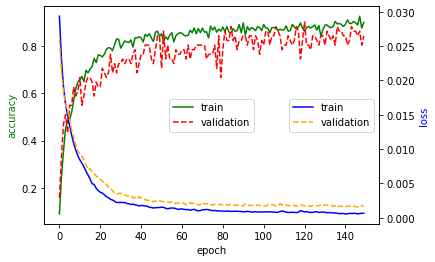

In [29]:
#history_1.history
#plot accuracy & loss 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history_1.history['accuracy'], color='g')
ax1.plot(history_1.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history_1.history['loss'], color='b')
ax2.plot(history_1.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center')
ax2.legend(['train', 'validation'], loc='center right')

fig.show()

In [30]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
bottleneck_representation.shape

(510, 16)

In [31]:
# Final features for expression
features_expr = pd.DataFrame(bottleneck_representation)
features_expr.index = X.index.values
features_expr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Case.ID_2000_Sample.ID_BA2123,0.792280,-0.495367,-0.017663,0.330463,-0.119250,0.382071,-0.508135,-0.436364,0.346684,-0.931376,0.196355,0.089434,-0.428633,-0.380432,0.338770,-0.449581
Case.ID_2002_Sample.ID_BA2111,0.027274,-0.120951,0.123442,-0.070588,0.004061,0.259209,0.507560,-0.031772,0.000292,-0.454211,-0.122870,-0.206915,0.178431,-0.475181,-0.052918,0.535581
Case.ID_2003_Sample.ID_BA2499,-0.140978,-0.283149,0.442254,-0.396705,-0.497956,0.154157,0.040001,0.085149,0.145086,0.486466,0.058202,0.147662,-0.631148,0.414157,0.092696,-0.592202
Case.ID_2004_Sample.ID_BA2846,0.552117,0.083460,-0.420554,0.007502,-0.093745,0.936124,-0.266789,0.662328,0.405196,0.179636,0.623769,0.117394,-0.212432,0.674409,-0.645689,-0.598824
Case.ID_2005_Sample.ID_BA2802,-0.381212,-0.952116,0.271686,0.328499,0.427726,-0.222544,-0.234269,0.504995,0.253183,0.427306,0.061752,0.656863,-0.150447,-0.217732,0.020432,0.467135


In [32]:
# PCA components for expression
pca_expr = pd.DataFrame(x_train)
pca_expr.index = X.index.values
pca_expr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Case.ID_2000_Sample.ID_BA2123,0.441926,0.235822,0.763656,0.822216,0.298674,0.543835,0.500114,0.237931,0.079947,0.864086,0.412655,0.723257,0.266265,0.238347,0.518292,0.368173,0.418640,0.703744,0.426135,0.609937
Case.ID_2002_Sample.ID_BA2111,0.629934,0.023786,0.409650,0.645049,0.486231,0.507838,0.605048,0.335428,0.265383,0.481286,0.517665,0.617042,0.412431,0.443558,0.662118,0.559354,0.473407,0.323181,0.559147,0.417169
Case.ID_2003_Sample.ID_BA2499,0.436339,0.186090,0.751453,0.544269,0.358588,0.441568,0.214053,0.428457,0.447679,0.359968,0.134412,0.216840,0.192043,0.319754,0.334726,0.450094,0.406386,0.230214,0.280561,0.611572
Case.ID_2004_Sample.ID_BA2846,0.261616,0.303258,0.404236,0.527118,0.166031,0.577304,0.650864,0.317022,0.378704,0.306809,0.000000,0.732575,0.602013,0.266732,0.239535,0.401378,0.639781,0.451323,0.347675,0.296327
Case.ID_2005_Sample.ID_BA2802,0.349691,0.179530,0.582357,0.165783,0.493540,0.246844,0.270483,0.432634,0.321571,0.400800,0.427908,0.357024,0.570935,0.124436,0.587434,0.513924,0.658190,0.460184,0.803689,0.288363


### 2. Autoenocder RNA-seq Junction Counts

In [33]:
#Build Autoencoder to Select Features

# PCA
n_input = 20
x_train = PCA(n_components = n_input).fit_transform(X2)
x_train = MinMaxScaler().fit_transform(x_train)
# Autoencoder
model = Sequential()

# Encoder
model.add(Dense(256,       activation='elu', input_shape=(n_input,)))  
model.add(Dense(128,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(32,       activation='elu'))

# Bottleneck
model.add(Dense(16,        activation='linear', name="bottleneck"))

# Decoder
model.add(Dense(32,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(128,       activation='elu'))
model.add(Dense(256,       activation='elu'))

# Output layer
model.add(Dense(n_input,  activation='sigmoid'))

# Compile
model.compile(loss = 'mean_squared_error', 
              optimizer = Adam(lr = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
bottleneck (Dense)           (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_20 (Dense)             (None, 64)               

In [34]:

# Fit
history_2 = model.fit(x_train, x_train, epochs=150, batch_size=32, shuffle=True, validation_split=0.1, verbose = 0)


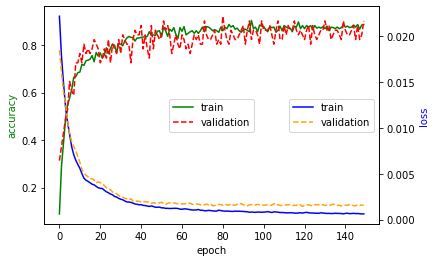

In [35]:
#history_2.history
#plot accuracy & loss 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history_2.history['accuracy'], color='g')
ax1.plot(history_2.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history_2.history['loss'], color='b')
ax2.plot(history_2.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center')
ax2.legend(['train', 'validation'], loc='center right')

fig.show()

In [36]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
bottleneck_representation.shape

(510, 16)

In [37]:
# Final features for junction counts
features_junction = pd.DataFrame(bottleneck_representation)
features_junction.index = X2.index.values
features_junction.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Case.ID_2000_Sample.ID_BA2123,-0.091873,0.289386,-0.613266,-0.567790,-0.054020,-0.277383,0.871378,-0.041680,-0.218038,0.104096,0.257713,-0.341605,0.489809,0.368546,-0.213244,0.809363
Case.ID_2002_Sample.ID_BA2111,-0.697168,1.226955,0.057504,-0.386618,-0.623169,-0.275675,0.388437,0.559498,0.366277,0.069983,-0.060664,0.256629,0.810871,-0.339802,-0.165503,0.685085
Case.ID_2003_Sample.ID_BA2499,-0.993852,-0.165525,-0.646099,-0.363554,-0.528787,0.230888,1.099432,-0.025122,0.662087,-0.329318,-0.098025,0.200002,-0.032704,-0.300355,0.712930,-0.148312
Case.ID_2004_Sample.ID_BA2846,-0.760615,0.101875,-0.186474,0.629840,-0.830049,0.124018,0.408669,-0.526762,-0.272718,0.178618,0.117504,0.298979,0.042434,0.615377,-0.571685,0.451377
Case.ID_2005_Sample.ID_BA2802,-0.250950,-0.030937,-0.105343,-0.543671,0.549653,-0.487464,1.224248,-0.102977,0.143538,-0.161288,-0.695022,-0.151111,-0.279103,-0.753704,0.275067,-0.142863


In [38]:
# PCA components for junction counts
pca_junction = pd.DataFrame(x_train)
pca_junction.index = X2.index.values
pca_junction.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Case.ID_2000_Sample.ID_BA2123,0.337736,0.320699,0.760979,0.516853,0.601528,0.627709,0.396984,0.172505,0.198522,0.203989,0.472659,0.370560,0.448557,0.531653,0.574121,0.287107,0.418222,0.300795,0.703037,0.486061
Case.ID_2002_Sample.ID_BA2111,0.440695,0.173557,0.771055,0.237200,0.485828,0.687239,0.460133,0.368879,0.415859,0.366331,0.497752,0.500784,0.391299,0.476319,0.520496,0.437628,0.451418,0.611991,0.294112,0.417517
Case.ID_2003_Sample.ID_BA2499,0.460752,0.404210,0.583866,0.525340,0.423427,0.255357,0.767232,0.608974,0.512528,0.369133,0.597609,0.155128,0.429202,0.377952,0.505056,0.196851,0.449374,0.588800,0.497672,0.603047
Case.ID_2004_Sample.ID_BA2846,0.267465,0.350529,0.429721,0.610082,0.440252,0.625483,0.734319,0.323669,0.354294,0.391344,0.625240,0.292107,0.798064,0.406510,0.424779,0.304517,0.235128,0.308975,0.388458,0.451368
Case.ID_2005_Sample.ID_BA2802,0.381840,0.338664,0.468969,0.280556,0.363261,0.022435,0.562057,0.413405,0.316613,0.511461,0.424957,0.363825,0.347799,0.479555,0.625005,0.332762,0.327267,0.502787,0.536044,0.315543


### 3. Autoenocder Somatic Mutations

In [39]:
#Build Autoencoder to Select Features

# PCA
n_input = 20
x_train = PCA(n_components = n_input).fit_transform(X3)
x_train = MinMaxScaler().fit_transform(x_train)
# Autoencoder
model = Sequential()

# Encoder
model.add(Dense(256,       activation='elu', input_shape=(n_input,)))  #anything larger than 1024 doesnt give good results
model.add(Dense(128,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(32,       activation='elu'))

# Bottleneck
model.add(Dense(16,        activation='linear', name="bottleneck"))

# Decoder
model.add(Dense(32,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(128,       activation='elu'))
model.add(Dense(256,       activation='elu'))

# Output layer
model.add(Dense(n_input,  activation='sigmoid'))

# Compile
model.compile(loss = 'mean_squared_error', 
              optimizer = Adam(lr = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
bottleneck (Dense)           (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_29 (Dense)             (None, 64)               

In [40]:

# Fit
history_3 = model.fit(x_train, x_train, epochs=150, batch_size=32, shuffle=True, validation_split=0.1, verbose = 0)


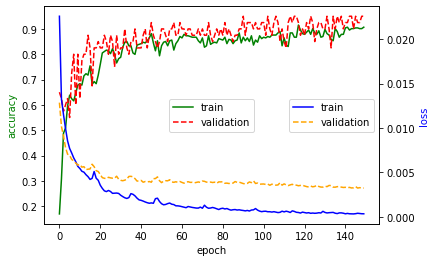

In [41]:
#history_3.history
#plot accuracy & loss 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history_3.history['accuracy'], color='g')
ax1.plot(history_3.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history_3.history['loss'], color='b')
ax2.plot(history_3.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center')
ax2.legend(['train', 'validation'], loc='center right')
fig.show()

In [42]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
bottleneck_representation.shape

(394, 16)

In [43]:
# Final features for somatic mutations
features_somatic = pd.DataFrame(bottleneck_representation)
features_somatic.index = X3.index.values
features_somatic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Case.ID_2000_Sample.ID_BA2123,-0.604933,-0.588719,0.237931,-0.056794,-0.991531,0.372150,0.077943,0.483791,1.200396,0.684248,0.564567,0.041030,-0.639731,-0.076105,0.404356,0.695353
Case.ID_2001_Sample.ID_BA2702,0.071025,0.186709,-0.084583,-0.116471,-0.550002,-0.526109,-0.258419,0.108038,0.539373,-0.224813,-0.185232,-0.111075,-1.171167,-0.329579,0.418587,0.701844
Case.ID_2003_Sample.ID_BA2499,0.098026,0.055566,0.125089,-0.690639,-0.788829,-0.479721,0.459009,0.010617,-0.082841,0.304339,0.567872,-0.590230,-0.412438,-0.132008,0.235835,0.112454
Case.ID_2004_Sample.ID_BA2846,-0.310764,-0.290460,-0.097422,-0.069403,-0.393123,-0.132574,0.257383,0.426463,0.539475,0.836330,1.200330,0.112764,-1.014869,-0.035600,0.868277,-0.018349
Case.ID_2006_Sample.ID_BA2665,-0.068514,0.034057,-0.170706,0.053622,-0.601297,-0.676016,0.301351,-0.055523,0.153288,-0.102775,-0.087411,0.027580,-1.180697,0.018084,0.556645,0.296150


In [44]:
# PCA components for somatic mutations
pca_somatic = pd.DataFrame(x_train)
pca_somatic.index = X3.index.values
pca_somatic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Case.ID_2000_Sample.ID_BA2123,0.028742,0.389853,0.216867,0.496892,0.310353,0.317525,0.400224,0.350269,0.528911,0.209116,0.496399,0.244739,0.247491,0.395702,0.276733,0.073394,0.193428,0.469120,0.584623,0.265646
Case.ID_2001_Sample.ID_BA2702,0.081619,0.304223,0.393880,0.128640,0.329983,0.370004,0.403814,0.405718,0.366398,0.247006,0.431584,0.346633,0.323148,0.551353,0.276380,0.109291,0.194502,0.453292,0.381216,0.535895
Case.ID_2003_Sample.ID_BA2499,0.068202,0.750767,0.276353,0.293660,0.234261,0.615858,0.488728,0.409065,0.241124,0.339227,0.453588,0.189668,0.432061,0.281738,0.351952,0.220994,0.315649,0.415967,0.325643,0.450908
Case.ID_2004_Sample.ID_BA2846,0.045508,0.600819,0.534379,0.547370,0.350462,0.395168,0.451888,0.341355,0.381949,0.288427,0.384823,0.236546,0.239367,0.257139,0.332741,0.261329,0.325042,0.442538,0.438106,0.485597
Case.ID_2006_Sample.ID_BA2665,0.038241,0.357459,0.399702,0.067022,0.351188,0.393912,0.405034,0.393340,0.324345,0.240367,0.376401,0.331541,0.337531,0.295854,0.378854,0.283658,0.312313,0.417079,0.416900,0.533499


### 4. Autoenocder Germline Mutations

In [45]:
#Build Autoencoder to Select Features

# PCA
n_input = 20
x_train = PCA(n_components = n_input).fit_transform(X4)
x_train = MinMaxScaler().fit_transform(x_train)
# Autoencoder
model = Sequential()

# Encoder
model.add(Dense(256,       activation='elu', input_shape=(n_input,)))  #anything larger than 1024 doesnt give good results
model.add(Dense(128,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(32,       activation='elu'))

# Bottleneck
model.add(Dense(16,        activation='linear', name="bottleneck"))

# Decoder
model.add(Dense(32,       activation='elu'))
model.add(Dense(64,       activation='elu'))
model.add(Dense(128,       activation='elu'))
model.add(Dense(256,       activation='elu'))

# Output layer
model.add(Dense(n_input,  activation='sigmoid'))

# Compile
model.compile(loss = 'mean_squared_error', 
              optimizer = Adam(lr = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
bottleneck (Dense)           (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_38 (Dense)             (None, 64)               

In [46]:

# Fit
history_4 = model.fit(x_train, x_train, epochs=150, batch_size=32, shuffle=True, validation_split=0.1, verbose = 0)


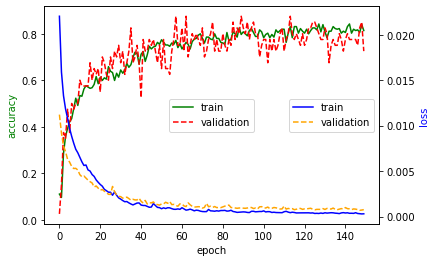

In [47]:
#history_4.history
#plot accuracy & loss 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history_4.history['accuracy'], color='g')
ax1.plot(history_4.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history_4.history['loss'], color='b')
ax2.plot(history_4.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center')
ax2.legend(['train', 'validation'], loc='center right')

fig.show()

In [48]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
bottleneck_representation.shape

(394, 16)

In [49]:
# Final features for germline mutations
features_germline = pd.DataFrame(bottleneck_representation)
features_germline.index = X4.index.values
features_germline.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Case.ID_2000_Sample.ID_BA2123,0.263536,-0.970761,1.415545,-0.031022,0.379617,-0.125064,0.643748,0.595392,-1.005761,0.864557,0.632182,0.060914,0.453462,0.948549,-0.158093,-0.522561
Case.ID_2001_Sample.ID_BA2702,0.506661,-0.599258,0.552395,-0.259265,1.275450,-0.240015,0.554744,1.106073,-0.545120,0.260250,0.694726,0.037510,-0.000436,-0.045674,0.246563,-0.405117
Case.ID_2003_Sample.ID_BA2499,0.453703,-1.031456,0.834228,-0.117858,0.798153,-0.332864,0.590801,0.781685,-1.038291,0.642398,0.759649,0.036333,0.102128,0.406094,-0.195979,-0.253502
Case.ID_2004_Sample.ID_BA2846,0.214851,-0.257145,-0.157292,0.231299,0.667755,-0.273544,0.661984,1.298033,-0.619963,-0.029188,0.368723,0.274682,0.239381,-0.106862,0.269139,-0.557046
Case.ID_2006_Sample.ID_BA2665,0.858990,-0.956644,0.743441,0.051107,0.841124,0.126260,0.052150,1.219755,-0.778193,0.241717,0.663074,0.103389,0.202483,0.005350,-0.206431,-0.456643


In [50]:
# PCA components for germline mutations
pca_germline = pd.DataFrame(x_train)
pca_germline.index = X4.index.values
pca_germline.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Case.ID_2000_Sample.ID_BA2123,0.156629,0.512160,0.322865,0.343850,0.282141,0.271789,0.103666,0.506253,0.287930,0.358636,0.597582,0.556410,0.805281,0.676094,0.366249,0.464024,0.233546,0.585681,0.461761,0.480570
Case.ID_2001_Sample.ID_BA2702,0.366146,0.124868,0.410181,0.480387,0.217157,0.199788,0.126330,0.473623,0.336718,0.373460,0.443589,0.419153,0.436722,0.513586,0.387724,0.350029,0.310191,0.515309,0.454498,0.448743
Case.ID_2003_Sample.ID_BA2499,0.263211,0.285806,0.334606,0.407285,0.255687,0.289361,0.095745,0.462926,0.240758,0.382153,0.552458,0.432270,0.679604,0.535571,0.358015,0.474773,0.319090,0.505166,0.532900,0.435318
Case.ID_2004_Sample.ID_BA2846,0.315520,0.229159,0.489261,0.513609,0.255586,0.139098,0.211630,0.454251,0.357930,0.418768,0.298509,0.302343,0.335416,0.386498,0.529326,0.429500,0.455049,0.396028,0.368433,0.369839
Case.ID_2006_Sample.ID_BA2665,0.286428,0.261822,0.330613,0.388575,0.250859,0.159044,0.124365,0.490850,0.359175,0.356745,0.532080,0.365915,0.359477,0.496724,0.435696,0.523479,0.376745,0.567639,0.472706,0.377136


## Prepare Drug Response Data

Drug sensitivity assay was run for 122 drugs on 408 samples. Results are presneted as IC50 values. IC50 is the concentration of drug at which 50% of your target is inhibited. The larger IC50 value implies weaker enzyme inhibitor binding. Also, there is about 20% missingness in IC50 values. I imputated missing values with mean.


In [54]:
amldrug = pd.read_csv('/users/PAS1203/osu1039/BeatAML-tables/drug/BeatAML_Drug_Responses_Matrix_IC50.txt', 
                      sep='\t', index_col=0)
print(amldrug.shape)

(122, 408)


In [55]:
amldrug.head()

,Case.ID_2003_Sample.ID_BA2499,Case.ID_2005_Sample.ID_BA2802,Case.ID_2007_Sample.ID_BA2918,Case.ID_2008_Sample.ID_BA2676,Case.ID_2010_Sample.ID_BA2304,Case.ID_2013_Sample.ID_BA2195,Case.ID_2014_Sample.ID_BA2226,Case.ID_2015_Sample.ID_BA2861,Case.ID_2017_Sample.ID_BA2156,Case.ID_2018_Sample.ID_BA2950,...,Case.ID_2580_Sample.ID_BA3042,Case.ID_2582_Sample.ID_BA3049,Case.ID_2584_Sample.ID_BA3053,Case.ID_2589_Sample.ID_BA3064,Case.ID_2590_Sample.ID_BA3065,Case.ID_2591_Sample.ID_BA3067,Case.ID_2591_Sample.ID_BA3068,Case.ID_2592_Sample.ID_BA3070,Case.ID_2592_Sample.ID_BA3071,Case.ID_2592_Sample.ID_BA3072
inhibitor,,,,,,,,,,,,,,,,,,,,,
17-AAG (Tanespimycin),6.319638,10.000000,NaN,0.830788,0.098336,4.521296,0.013717,0.920575,10.000000,0.090870,...,10.000000,1.129969,0.067907,0.037138,0.694600,1.185671,NaN,NaN,0.067511,0.510429
A-674563,0.241698,4.033889,1.436478,3.421091,0.063688,0.641586,0.105956,0.667541,3.420715,0.766284,...,0.344736,0.427758,0.066841,0.353842,0.035080,0.349881,NaN,NaN,0.185764,0.192183
ABT-737,5.783888,1.845668,NaN,0.681000,10.000000,10.000000,0.421384,3.628361,8.423793,1.254340,...,0.050819,10.000000,0.160295,0.134578,4.810066,NaN,NaN,NaN,NaN,NaN
Afatinib (BIBW-2992),0.569971,0.960295,4.727013,2.214890,3.649317,1.032933,0.687313,1.376458,0.811823,4.176852,...,6.804809,1.230673,0.438223,0.757613,0.253062,1.311494,NaN,NaN,0.250964,0.363497
Alisertib (MLN8237),10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.861105,10.000000,4.056564,5.951410,...,10.000000,10.000000,6.194324,4.363173,1.749522,10.000000,NaN,NaN,5.377153,10.000000


In [56]:
print(amldrug.isnull().sum()/122*100)  #what percentage is null for each sample

Case.ID_2003_Sample.ID_BA2499    18.852459
Case.ID_2005_Sample.ID_BA2802    20.491803
Case.ID_2007_Sample.ID_BA2918    30.327869
Case.ID_2008_Sample.ID_BA2676    14.754098
Case.ID_2010_Sample.ID_BA2304    13.934426
                                   ...    
Case.ID_2591_Sample.ID_BA3067     9.016393
Case.ID_2591_Sample.ID_BA3068    85.245902
Case.ID_2592_Sample.ID_BA3070    86.065574
Case.ID_2592_Sample.ID_BA3071     8.196721
Case.ID_2592_Sample.ID_BA3072    14.754098
Length: 408, dtype: float64


In [57]:
#Impute with mean
amldrug.fillna(amldrug.mean(), inplace = True)
#print(amldrug.isnull().sum())

In [59]:
Y = amldrug.T
Y.head(3)

inhibitor,17-AAG (Tanespimycin),A-674563,ABT-737,Afatinib (BIBW-2992),Alisertib (MLN8237),AT7519,Axitinib (AG-013736),AZD1480,Barasertib (AZD1152-HQPA),Bay 11-7085,...,Vandetanib (ZD6474),Vargetef,Vatalanib (PTK787),Vemurafenib (PLX-4032),Venetoclax,Vismodegib (GDC-0449),Volasertib (BI-6727),VX-745,XAV-939,YM-155
Case.ID_2003_Sample.ID_BA2499,6.319638,0.241698,5.783888,0.569971,10.0,0.198358,10.0,10.0,10.0,6.909064,...,10.0,2.330211,10.000000,10.000000,6.909064,10.000000,6.909064,3.20411,10.000000,1.000000
Case.ID_2005_Sample.ID_BA2802,10.000000,4.033889,1.845668,0.960295,10.0,0.522922,10.0,10.0,10.0,6.713810,...,10.0,2.303597,0.013717,6.713810,6.713810,10.000000,6.713810,10.00000,10.000000,1.000000
Case.ID_2007_Sample.ID_BA2918,6.545511,1.436478,6.545511,4.727013,10.0,10.000000,10.0,10.0,10.0,6.545511,...,10.0,2.686791,4.686475,6.545511,6.545511,6.545511,6.545511,10.00000,6.545511,0.136231


## Final DNN Model

For the final DNN model, I tested wide range of hyperparameters. I changed number of layers, number of nodes in each layer, dropout rate and learning rate. 

Changing hyperparameters helped with reducing loss function and addressing overfitting issue (slightly), but none of the models were able to generate acceptable accuracy values.

I also tried to setup DNN model only using RNA-seq data (gene expression and junction counts) and only variant data (somatic and germline). This approach also resulted in similar model accuracy issues. 


In [65]:
# Dataframe for expression and junction counts features
df1 = pd.concat([features_expr.iloc[:, : 16], features_junction.iloc[:, : 16]], axis=1, join='inner')

# Dataframe for somatic and germline mutation features
df2 = pd.concat([features_somatic.iloc[:, : 16], features_germline.iloc[:, : 16]], axis=1, join='inner')

# Dataframe with all omics features
df = pd.concat([df1, df2], axis=1, join='inner')

print(df1.shape)
print(df2.shape)
print(df.shape)

(510, 32)
(394, 32)
(272, 64)


In [66]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,6,7,8,9,10,11,12,13,14,15
Case.ID_2000_Sample.ID_BA2123,0.792280,-0.495367,-0.017663,0.330463,-0.119250,0.382071,-0.508135,-0.436364,0.346684,-0.931376,...,0.643748,0.595392,-1.005761,0.864557,0.632182,0.060914,0.453462,0.948549,-0.158093,-0.522561
Case.ID_2003_Sample.ID_BA2499,-0.140978,-0.283149,0.442254,-0.396705,-0.497956,0.154157,0.040001,0.085149,0.145086,0.486466,...,0.590801,0.781685,-1.038291,0.642398,0.759649,0.036333,0.102128,0.406094,-0.195979,-0.253502
Case.ID_2004_Sample.ID_BA2846,0.552117,0.083460,-0.420554,0.007502,-0.093745,0.936124,-0.266789,0.662328,0.405196,0.179636,...,0.661984,1.298033,-0.619963,-0.029188,0.368723,0.274682,0.239381,-0.106862,0.269139,-0.557046
Case.ID_2008_Sample.ID_BA2676,0.348378,-0.482237,-0.365931,-0.890326,-0.160767,0.410812,-0.160918,0.530005,0.065686,0.793087,...,1.111403,1.000709,-0.928933,0.420731,0.622512,0.274269,0.708255,0.480510,-0.030169,-0.198652
Case.ID_2013_Sample.ID_BA2195,0.420941,-0.127754,-0.180928,0.373014,0.068182,0.085890,-0.543430,-0.011341,0.168802,0.670854,...,0.170652,0.911726,0.254389,0.314762,0.090161,0.286331,-0.266982,1.053615,0.550922,-0.492916


In [68]:
# Match rows with Y (drug response)
# There must be a much easier way to match row names, but I couldn't find it :(
i1 = df.shape[1]
df = pd.concat([df, Y], axis=1, join='inner')
i2 = df.shape[1]

In [69]:
# Prepare input and output prediction for DNN model
XX = df.iloc[:, :i1]
YY = df.iloc[:, i1:i2] 

XX = MinMaxScaler().fit_transform(XX)
YY = MinMaxScaler().fit_transform(YY)

print(XX.shape)
print(YY.shape)

(186, 64)
(186, 122)


In [71]:
N_FEATURES = XX.shape[1]
N_TARGETS = YY.shape[1]

print(N_FEATURES)
print(N_TARGETS)

64
122


In [89]:
# Build DNN model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
#model.add(Dense(N_FEATURES, activation='relu'))
model.add(Dense(1024, activation='relu', input_shape=(N_FEATURES,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(N_TARGETS, activation='relu')) 

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)              

In [90]:
history = model.fit(XX, YY, epochs=150, verbose=1, validation_split=0.2)
#

Epoch 1/150
5/5 [==============================] - 0s 22ms/step - loss: 0.4030 - accuracy: 0.0135 - val_loss: 0.4085 - val_accuracy: 0.0000e+00
Epoch 2/150
5/5 [==============================] - 0s 7ms/step - loss: 0.3724 - accuracy: 0.0270 - val_loss: 0.3720 - val_accuracy: 0.0000e+00
Epoch 3/150
5/5 [==============================] - 0s 11ms/step - loss: 0.3360 - accuracy: 0.0068 - val_loss: 0.3333 - val_accuracy: 0.0000e+00
Epoch 4/150
5/5 [==============================] - 0s 9ms/step - loss: 0.3084 - accuracy: 0.0068 - val_loss: 0.3001 - val_accuracy: 0.0000e+00
Epoch 5/150
5/5 [==============================] - 0s 11ms/step - loss: 0.2866 - accuracy: 0.0203 - val_loss: 0.2750 - val_accuracy: 0.0000e+00
Epoch 6/150
5/5 [==============================] - 0s 12ms/step - loss: 0.2678 - accuracy: 0.0000e+00 - val_loss: 0.2538 - val_accuracy: 0.0000e+00
Epoch 7/150
5/5 [==============================] - 0s 11ms/step - loss: 0.2496 - accuracy: 0.0000e+00 - val_loss: 0.2354 - val_accurac

Epoch 57/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1408 - accuracy: 0.0000e+00 - val_loss: 0.1480 - val_accuracy: 0.0000e+00
Epoch 58/150
5/5 [==============================] - 0s 9ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - val_loss: 0.1474 - val_accuracy: 0.0000e+00
Epoch 59/150
5/5 [==============================] - 0s 8ms/step - loss: 0.1378 - accuracy: 0.0000e+00 - val_loss: 0.1474 - val_accuracy: 0.0000e+00
Epoch 60/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1395 - accuracy: 0.0068 - val_loss: 0.1505 - val_accuracy: 0.0000e+00
Epoch 61/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1374 - accuracy: 0.0000e+00 - val_loss: 0.1475 - val_accuracy: 0.0000e+00
Epoch 62/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1377 - accuracy: 0.0000e+00 - val_loss: 0.1467 - val_accuracy: 0.0000e+00
Epoch 63/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1393 - accuracy: 0.0000e+00 - val_los

5/5 [==============================] - 0s 10ms/step - loss: 0.1286 - accuracy: 0.0000e+00 - val_loss: 0.1480 - val_accuracy: 0.0000e+00
Epoch 113/150
5/5 [==============================] - 0s 10ms/step - loss: 0.1274 - accuracy: 0.0068 - val_loss: 0.1488 - val_accuracy: 0.0000e+00
Epoch 114/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1279 - accuracy: 0.0000e+00 - val_loss: 0.1486 - val_accuracy: 0.0000e+00
Epoch 115/150
5/5 [==============================] - 0s 9ms/step - loss: 0.1264 - accuracy: 0.0000e+00 - val_loss: 0.1496 - val_accuracy: 0.0000e+00
Epoch 116/150
5/5 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.0000e+00 - val_loss: 0.1478 - val_accuracy: 0.0000e+00
Epoch 117/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1262 - accuracy: 0.0000e+00 - val_loss: 0.1485 - val_accuracy: 0.0000e+00
Epoch 118/150
5/5 [==============================] - 0s 11ms/step - loss: 0.1254 - accuracy: 0.0000e+00 - val_loss: 0.15

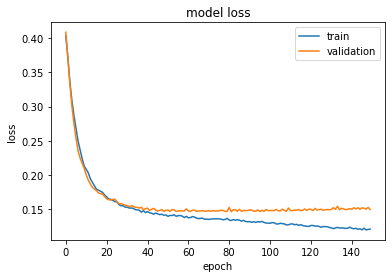

In [91]:

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()




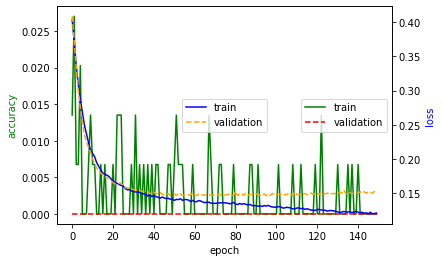

In [92]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], color='g')
ax1.plot(history.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history.history['loss'], color='b')
ax2.plot(history.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center right')
ax2.legend(['train', 'validation'], loc='center')

fig.show()

### DNN with only RNA-seq data (expression & junction)

In [94]:
# Match rows with Y (drug response)
# There must be a much easier way to match row names, but I couldn't find it :(
i1 = df1.shape[1]
df1 = pd.concat([df1, Y], axis=1, join='inner')
i2 = df1.shape[1]
# Prepare input and output prediction for DNN model
XX = df1.iloc[:, :i1]
YY = df1.iloc[:, i1:i2] 

XX = MinMaxScaler().fit_transform(XX)
YY = MinMaxScaler().fit_transform(YY)

print(XX.shape)
print(YY.shape)

N_FEATURES = XX.shape[1]
N_TARGETS = YY.shape[1]

print(N_FEATURES)
print(N_TARGETS)

(348, 32)
(348, 122)
32
122


In [95]:
# Build DNN model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
#model.add(Dense(N_FEATURES, activation='relu'))
model.add(Dense(1024, activation='relu', input_shape=(N_FEATURES,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(N_TARGETS, activation='relu')) 

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)             

In [96]:
history = model.fit(XX, YY, epochs=150, verbose=1, validation_split=0.2)
#

Epoch 1/150
9/9 [==============================] - 0s 14ms/step - loss: 0.4124 - accuracy: 0.0000e+00 - val_loss: 0.3841 - val_accuracy: 0.0000e+00
Epoch 2/150
9/9 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.0000e+00 - val_loss: 0.3247 - val_accuracy: 0.0000e+00
Epoch 3/150
9/9 [==============================] - 0s 7ms/step - loss: 0.3014 - accuracy: 0.0000e+00 - val_loss: 0.2614 - val_accuracy: 0.0000e+00
Epoch 4/150
9/9 [==============================] - 0s 6ms/step - loss: 0.2551 - accuracy: 0.0000e+00 - val_loss: 0.2241 - val_accuracy: 0.0000e+00
Epoch 5/150
9/9 [==============================] - 0s 8ms/step - loss: 0.2285 - accuracy: 0.0000e+00 - val_loss: 0.1943 - val_accuracy: 0.0000e+00
Epoch 6/150
9/9 [==============================] - 0s 7ms/step - loss: 0.2005 - accuracy: 0.0036 - val_loss: 0.1745 - val_accuracy: 0.0000e+00
Epoch 7/150
9/9 [==============================] - 0s 8ms/step - loss: 0.1841 - accuracy: 0.0000e+00 - val_loss: 0.1606 -

Epoch 57/150
9/9 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - val_loss: 0.1274 - val_accuracy: 0.0000e+00
Epoch 58/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1235 - accuracy: 0.0000e+00 - val_loss: 0.1276 - val_accuracy: 0.0000e+00
Epoch 59/150
9/9 [==============================] - 0s 6ms/step - loss: 0.1246 - accuracy: 0.0000e+00 - val_loss: 0.1280 - val_accuracy: 0.0000e+00
Epoch 60/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1239 - accuracy: 0.0000e+00 - val_loss: 0.1277 - val_accuracy: 0.0000e+00
Epoch 61/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1234 - accuracy: 0.0036 - val_loss: 0.1274 - val_accuracy: 0.0000e+00
Epoch 62/150
9/9 [==============================] - 0s 8ms/step - loss: 0.1229 - accuracy: 0.0000e+00 - val_loss: 0.1278 - val_accuracy: 0.0000e+00
Epoch 63/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1239 - accuracy: 0.0000e+00 - val_loss: 0.

9/9 [==============================] - 0s 7ms/step - loss: 0.1121 - accuracy: 0.0000e+00 - val_loss: 0.1261 - val_accuracy: 0.0000e+00
Epoch 113/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1134 - accuracy: 0.0036 - val_loss: 0.1295 - val_accuracy: 0.0000e+00
Epoch 114/150
9/9 [==============================] - 0s 6ms/step - loss: 0.1127 - accuracy: 0.0036 - val_loss: 0.1264 - val_accuracy: 0.0000e+00
Epoch 115/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.0000e+00 - val_loss: 0.1258 - val_accuracy: 0.0000e+00
Epoch 116/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.0000e+00 - val_loss: 0.1296 - val_accuracy: 0.0000e+00
Epoch 117/150
9/9 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.0000e+00 - val_loss: 0.1263 - val_accuracy: 0.0000e+00
Epoch 118/150
9/9 [==============================] - 0s 6ms/step - loss: 0.1105 - accuracy: 0.0000e+00 - val_loss: 0.1269 - val_

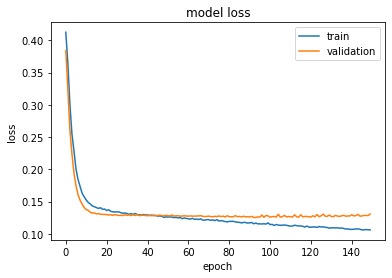

In [97]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

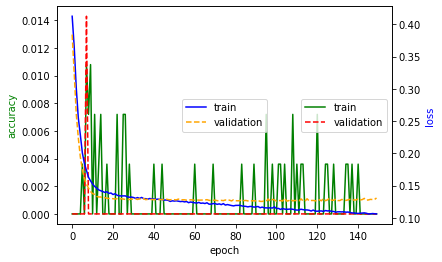

In [98]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], color='g')
ax1.plot(history.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history.history['loss'], color='b')
ax2.plot(history.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center right')
ax2.legend(['train', 'validation'], loc='center')

fig.show()

### DNN with only variant data (sormatic and germline)

In [100]:
# Match rows with Y (drug response)
# There must be a much easier way to match row names, but I couldn't find it :(
i1 = df2.shape[1]
df2 = pd.concat([df2, Y], axis=1, join='inner')
i2 = df2.shape[1]
# Prepare input and output prediction for DNN model
XX = df2.iloc[:, :i1]
YY = df2.iloc[:, i1:i2] 

XX = MinMaxScaler().fit_transform(XX)
YY = MinMaxScaler().fit_transform(YY)

print(XX.shape)
print(YY.shape)

N_FEATURES = XX.shape[1]
N_TARGETS = YY.shape[1]

print(N_FEATURES)
print(N_TARGETS)

(220, 32)
(220, 122)
32
122


In [112]:
# Build DNN model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
#model.add(Dense(N_FEATURES, activation='relu'))
model.add(Dense(1024, activation='relu', input_shape=(N_FEATURES,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(N_TARGETS, activation='relu')) 

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)             

In [113]:
history = model.fit(XX, YY, epochs=150, verbose=1, validation_split=0.2)
#

Epoch 1/150
6/6 [==============================] - 0s 25ms/step - loss: 0.4101 - accuracy: 0.0170 - val_loss: 0.4138 - val_accuracy: 0.0000e+00
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3821 - accuracy: 0.0000e+00 - val_loss: 0.3800 - val_accuracy: 0.0000e+00
Epoch 3/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3454 - accuracy: 0.0000e+00 - val_loss: 0.3384 - val_accuracy: 0.0000e+00
Epoch 4/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3041 - accuracy: 0.0000e+00 - val_loss: 0.2922 - val_accuracy: 0.0000e+00
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 0.2647 - accuracy: 0.0000e+00 - val_loss: 0.2526 - val_accuracy: 0.0000e+00
Epoch 6/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2370 - accuracy: 0.0000e+00 - val_loss: 0.2265 - val_accuracy: 0.0000e+00
Epoch 7/150
6/6 [==============================] - 0s 10ms/step - loss: 0.2177 - accuracy: 0.0000e+00 - val_loss: 0.2

6/6 [==============================] - 0s 8ms/step - loss: 0.1150 - accuracy: 0.0000e+00 - val_loss: 0.1262 - val_accuracy: 0.0000e+00
Epoch 57/150
6/6 [==============================] - 0s 9ms/step - loss: 0.1169 - accuracy: 0.0000e+00 - val_loss: 0.1226 - val_accuracy: 0.0000e+00
Epoch 58/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1163 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_accuracy: 0.0000e+00
Epoch 59/150
6/6 [==============================] - 0s 7ms/step - loss: 0.1148 - accuracy: 0.0000e+00 - val_loss: 0.1254 - val_accuracy: 0.0000e+00
Epoch 60/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1142 - accuracy: 0.0000e+00 - val_loss: 0.1241 - val_accuracy: 0.0000e+00
Epoch 61/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1186 - accuracy: 0.0000e+00 - val_loss: 0.1218 - val_accuracy: 0.0000e+00
Epoch 62/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1160 - accuracy: 0.0000e+00 - val_loss: 0.1247 - 

6/6 [==============================] - 0s 11ms/step - loss: 0.1101 - accuracy: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.0000e+00
Epoch 112/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1082 - accuracy: 0.0000e+00 - val_loss: 0.1215 - val_accuracy: 0.0000e+00
Epoch 113/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.0000e+00 - val_loss: 0.1238 - val_accuracy: 0.0000e+00
Epoch 114/150
6/6 [==============================] - 0s 10ms/step - loss: 0.1080 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_accuracy: 0.0000e+00
Epoch 115/150
6/6 [==============================] - 0s 9ms/step - loss: 0.1083 - accuracy: 0.0000e+00 - val_loss: 0.1242 - val_accuracy: 0.0000e+00
Epoch 116/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1232 - val_accuracy: 0.0000e+00
Epoch 117/150
6/6 [==============================] - 0s 9ms/step - loss: 0.1086 - accuracy: 0.0000e+00 - val_loss: 0.

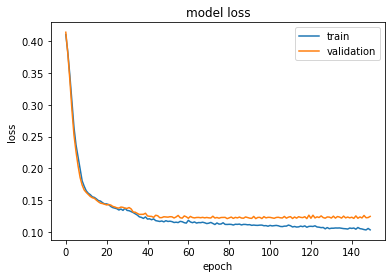

In [114]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

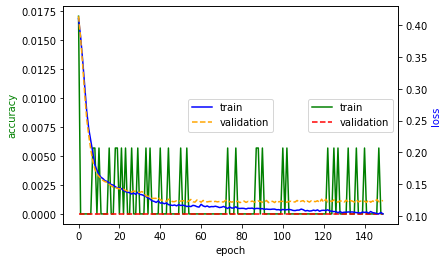

In [115]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], color='g')
ax1.plot(history.history['val_accuracy'], color='r', linestyle="--")
ax2.plot(history.history['loss'], color='b')
ax2.plot(history.history['val_loss'], color='orange', linestyle="--")

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color='g')
ax2.set_ylabel('loss', color='b')
ax1.legend(['train', 'validation'], loc='center right')
ax2.legend(['train', 'validation'], loc='center')

fig.show()

## Conclusions

PCA and autoencoders worked well to extact features from each omics data type. The approach helped reduce dimensionality of the data reasonably. However, I could not optimize the final DNN model for drug response prediction. Similar to Sharifi-Noghabi et. al. Bioinformatics 2019 paper, we might need to define a new loss function for more appropriate evaluation of the DNN model.
